# Data Science Project: Predicting Usage of a Video Game Research Server

# Introduction

### Background

This project investigated whether a Minecraft player's experience level can be predicted by their age and the number of hours played. A Minecraft server was set up by a research group in the Department of Computer Science at UBC, led by Frank Wood. Their objective was to record how players navigate the world. However, running this kind of research requires a lot of resources such as software licenses and server hardware. To use these resources efficiently, they must target players in their recruiting efforts that are most likely to contribute a large amount of data, in terms of played hours. 

To determine whether predictive modelling can be useful in their recruiting efforts, this project aims to discover the relationship between player characteristics and experience level using the K-nearest neighbour algorithm and to evaluate the effectiveness of the KNN classifier in this context to maximize data collection.

### Question

Can we predict a Minecraft player's experience level based on their age and the number of hours they have played?

### Data Description

In order to investigate the question, the players.csv data set will be used. This file includes information about the players and some data about each player. This data set has 7 variables and 196 observations. Each observation represents a player and some of their characteristics. The 7 variables include:

- experience: the player's experience level; Beginner, Amateur, Regular, Pro, and Veteran
- subscribe: whether or not the player would be interested in subscribing to a game-related newsletter
- hashedEmail: the player's encrypted email
- played_hours: the amount of hours the player played on the server
- name: the name of the player
- gender: the gender of the player
- Age: the age of the player

#### Issues with the data
1. Amongst the variables, there are 3 in particular that we are interested in using for our data analysis: `experience`, `played_hours`, and `Age`. So, in the data cleaning/wrangling step, we will create a subset of the columns specified using the `select()` function.

2. We noticed that the `experience` variable, our response variable, is stored as a character type. To make it suitable for the KNN algorithm, we will change it into a categorical variable using `as_factor()`. 

3. The functions `group_by()` and `summarise()` were used to see how many players of each experience level there are. From this analysis we notice that there is class imbalance amongst the levels. There are far fewer observations of the "Pro" experience level than "Amateur". To address this issue, an oversampling step will be added to the recipe using the `step_upsample()` function from the `themis` R package.

After loading the necessary packages and data, we will begin our analysis by addressing the issues above in order to make our data suitable for the analysis.

# Methods and Results
This section of the report will contain the codes that make up our analysis. There are notes in each cell, or above, that will narrate the analysis.

### Additional information

We decided that KNN classification was the appropriate method to use for this analysis because it is a very intuitive algorithm and our target variable (`experience level`) is categorical. The KNN model assumes that similar observations are near each other, therefore, the label of a new observation will be predicted based on the labels of nearby points. Since KNN relies on Euclidian distance to determine which points are the closest, we need to scale and center the predictor variables. 

Some potential weaknesses of KNN classification is that it can struggle with missing data and class imbalance, which was explored and will be addressed in our data set. 

To provide a brief overview of our analysis plan, we will first explore the data set and preprocess the data. We will then further examine the relationships by creating a scatter plot. Then, we will build our classifer. This process includes splitting the data into training and testing sets, tuning the model to select the optimal K value based on accuracy, and creating the recipe, model, and workflow. Finally, we will evaluate the classifier's performance by using the testing set.

Let's go!

In [1]:
# Run this cell before continuing
library(tidyverse)
library(tidymodels)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Loading the player data set
player_data <- read_csv("data/players.csv")

head(player_data) # to view the first few rows

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Exploring the data set

To wrangle the data and make it suitable for our analysis, we will be performing the following tasks:

- `select()` to create a subset with only the columns needed (experience and Age)
- `mutate()` + `as_factor()` to change the `experience` variable into a categorical variable,
- `mutate()` + `if_else()` + `na.rm = TRUE`, to impute any missing data using the mean of the available data

The results are assigned to an object called `player_wrangle`

In [3]:
player_wrangle <- player_data |>
                    select(experience, played_hours, Age) |>
                    mutate(experience = as_factor(experience),
                            played_hours = if_else(is.na(played_hours), mean(played_hours, na.rm = TRUE), played_hours),
                            Age = if_else(is.na(Age), mean(Age, na.rm = TRUE), Age))

head(player_wrangle) # to view the first few rows

experience,played_hours,Age
<fct>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
Amateur,0.7,21
Regular,0.1,21
Amateur,0.0,17


In [4]:
# Seeing how many of each experience level there is
exp_count <- player_wrangle |>
                group_by(experience) |>
                summarise(count = n())
exp_count

experience,count
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


From this summary, we can see that there is class imbalance, the `Amateur` level is much more common than `Pro`

### Preprocessing the data

Before balancing the classes, we will split the data set into training and testing sets, and apply the 'step_upsample' function to the training set. This prevents any information from the testing set leaking into the model during training.

We will split the data so that 70% of the original data goes into the training set and 30% into the testing set. Additionally, we will stratify by the `experience` variable so that a roughly equal proportion of each class will end up in both of the subsets.

In [5]:
# run this cell to split the data
set.seed(1234)
player_split <- initial_split(player_wrangle, prop = 0.70, strata = experience)
player_training <- training(player_split)
player_testing <- testing(player_split)

To address the class imbalance in the training set, we will use the `step_upsample()` function in our recipe to oversample the rare class and give them more voting power.

In [6]:
# Run this cell to balance the classes
player_recipe <- recipe(experience ~ played_hours + Age, data = player_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(experience, over_ratio = 1, skip = TRUE)

# Let's see if it worked
player_upsampled <- player_recipe |>
                        prep() |>
                        bake(new_data = NULL) |>
                        group_by(experience) |>
                        summarise(n = n())
player_upsampled

experience,n
<fct>,<int>
Pro,44
Veteran,44
Amateur,44
Regular,44
Beginner,44


### Exploring the data set: continued

Before we build our model, lets visualize the data using a scatter plot to explore the relationships between the variables and also to better understand the data set.

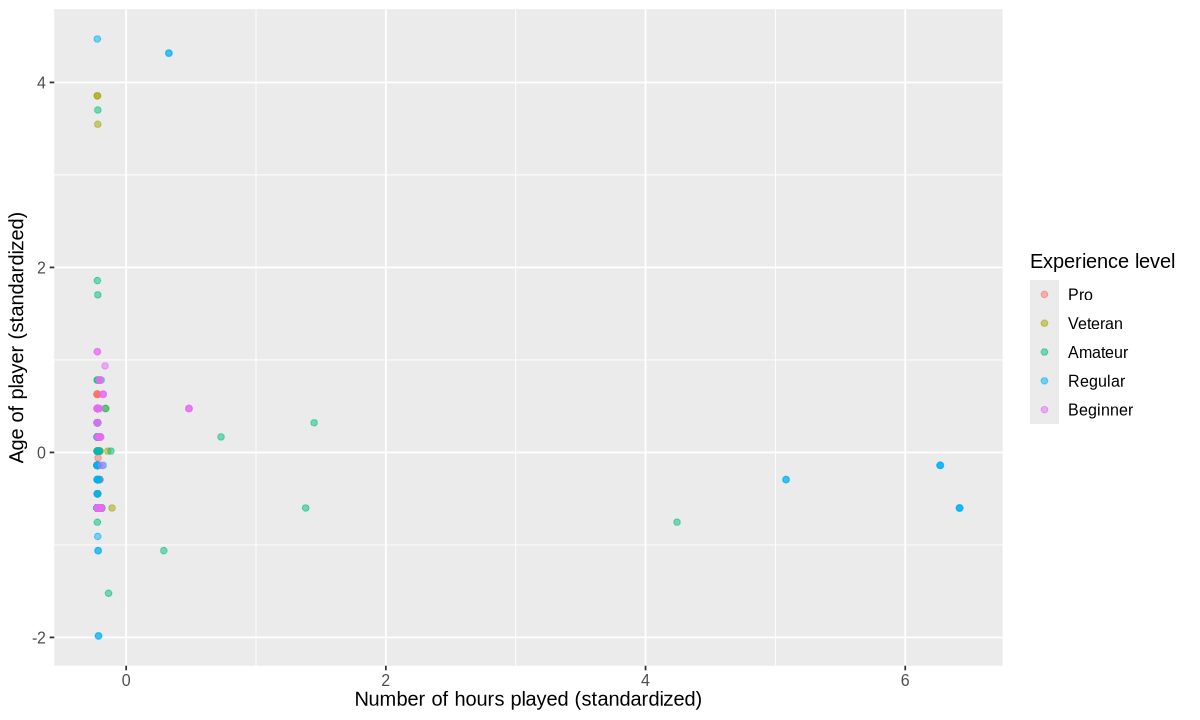

In [7]:
player_plot_data <- player_recipe |>
                        prep() |> # applies the preprocessing steps to the data
                        bake(new_data = NULL) # extract the transformed data frame

options(repr.plot.height = 6, repr.plot.width = 10) # specifies the sizes of the plot
player_plot <- player_plot_data |>
                 ggplot(aes(x = played_hours, y = Age, color = experience)) +
                 geom_point(alpha = 0.5) +
                 labs(x = "Number of hours played (standardized)",
                      y = "Age of player (standardized)",
                      color = "Experience level") +
                 theme(text = element_text(size = 12))
player_plot

This scatter plot doesn't display any strong relationship between the variables. The points for the different experience levels are highly mixed and doesn't show any patterns distinguishing the classes. 

We will note that the classifier may find it difficult to differentiate between the classes based on these 2 variables alone. But for now, let's continue with our analysis.

### Parameter value selection: choosing K

In order to choose our parameter K, k-fold cross validation will be performed using 5 folds and we will tune the model by evaluating its performance over a range of K values (1 to 100, stepping by 5)

→ A | warning: ✖ No observations were detected in `truth` for level: Pro.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





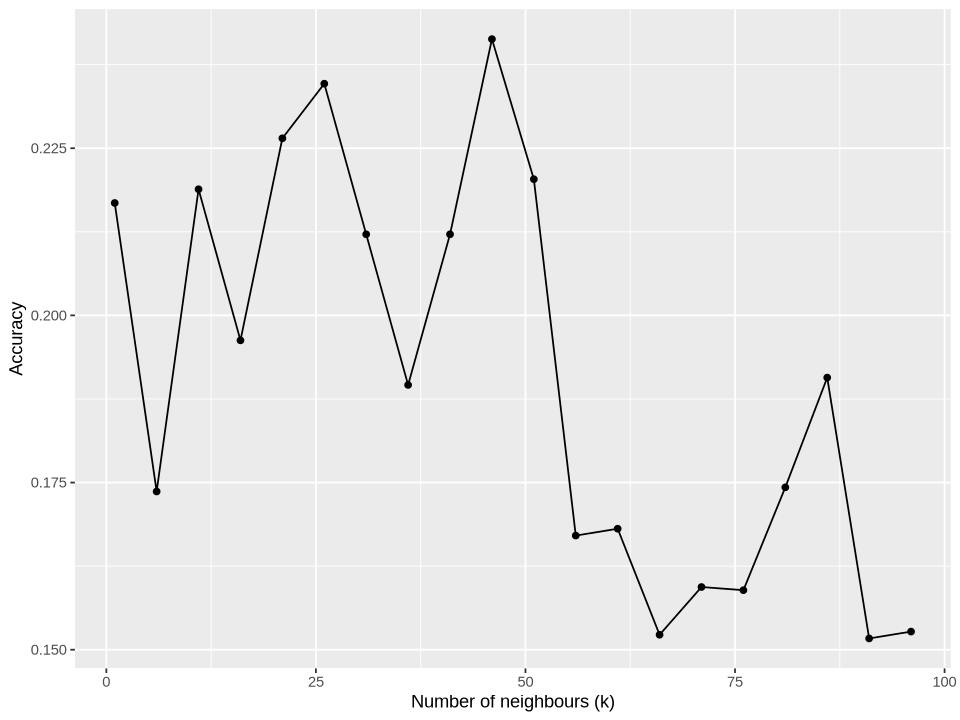

In [8]:
# setting a seed to make the results reproducible
set.seed(1234)

# create a model specification 
options(repr.plot.height = 6, repr.plot.width = 8)

knn_spec <- nearest_neighbor(weight_func = "rectangular", # specifying to give each neighbour 1 vote
                             neighbors = tune()) |> # to select the optimal value of K
                set_engine("kknn") |> # to perform KNN classification
                set_mode("classification") # to specify that this is a classification problem

training_vfold <- vfold_cv(player_training, v = 5, # to perform a 5-fold cross validation
                            strata = experience) # to ensure that the training and validation sets contain an equal proportion of classes 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) # to give a sequence of K values to try

knn_results <- workflow() |> # creating a workflow
                add_recipe(player_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = training_vfold, grid = k_vals) # to fit the model for each K value to try

# evaluate the classifiers performance for each K value
accuracies <- knn_results |>
                collect_metrics() |>
                filter(.metric == "accuracy")

# plot accuracy vs. K to decide how many neighbours to choose
cross_val_plot <- accuracies |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of neighbours (k)", y = "Accuracy")
cross_val_plot

In [9]:
# to obtain the K value with the highest accuracy
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 46

### Retraining the classifier

Now that we've obtained the optimal K value, we will retrain the classifier on the training set using the chosen K value (K = 46).

In [13]:
# Retraining the model, specifying that we want to use 46 nearest neighbours
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 46) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(player_recipe) |>
            add_model(knn_spec) |>
            fit(data = player_training) # to fit the model to the training set

### Evaluating on the testing set

Finally, we will evaluate the accuracy of our classifier using the testing set. A high accuracy will indicate that our classifier can predict data it has not seen before.

In [14]:
# evaluate the classifier using the testing set
player_predict <- knn_fit |>
                    predict(player_testing) |>
                    bind_cols(player_testing)

predict <- player_predict |>
  metrics(truth = experience, estimate = .pred_class) |>
  filter(.metric == "accuracy")
predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.2


# Discussion
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

Our KNN model achieved only about 20% accuracy in predicting Minecraft player's experience levels based on `Age` and `played_hours`. While this low performance could suggest that our classifier isn't effective, I believe it is more likely that the two predictor variables alone do not provide enough information to accurately distinguish between the experience level categories. 

The results were somewhat unexpected, as I assumed that players with more hours played would have higher experience levels. However, our findings indicate that predicting a player's experience is more complex than just the amount of hours spent on the server or age. Other factors such as achievements, combat skills, basic survival skills, and building abilities may be more relevant and indicative of a player's actual experience level.

Another important topic of discussion is the subjectivity involved in the self reported experience levels. What distinguishes a `Pro` player from a and `Regular` player? It's possible that the participants have misclassified themselves. To address this issue, future studies should provide a clear criteria or descriptions for each experience class to reduce uncertainty.

To broaden the scope of the study, future studies should incorporate more relevant variables or try other methods such as decision trees or neural networks. These suggestions could improve the accuracy of the classifier and improving our understanding of the target audience for recruiting efforts.